In [4]:
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator

In [5]:
load_dotenv()

True

In [6]:
essay ="""
The Rise of Artificial Intelligence
In recent years, Artificial Intelligence (AI) has emerged as one of the most transformative forces in modern technology. From self-driving cars and virtual assistants to advanced medical diagnostics and content creation, AI is rapidly reshaping industries and the way we live. The rise of AI is not just a technological trend; it represents a fundamental shift in how humans interact with machines, data, and the world around them.

The roots of AI can be traced back to the mid-20th century, when scientists first began exploring the idea of machines that could simulate human intelligence. However, progress was slow due to limited computing power and lack of data. The situation changed dramatically in the 21st century with the explosion of digital data, the development of powerful computing hardware, and breakthroughs in machine learning—particularly deep learning and neural networks. These advancements allowed AI systems to learn from massive datasets, recognize patterns, and make decisions with remarkable accuracy.

One of the most visible signs of AI's rise is its integration into everyday life. Voice assistants like Siri, Alexa, and Google Assistant use natural language processing to understand and respond to user queries. Recommendation algorithms on platforms like YouTube, Netflix, and Amazon use AI to predict what users will like. In healthcare, AI helps doctors analyze medical images, predict disease outbreaks, and even assist in surgeries. In business, AI streamlines operations, enhances customer service, and enables data-driven decision-making.

Despite its many benefits, the rise of AI also brings significant concerns. One major issue is job displacement. As AI systems become more capable, they may replace human workers in fields such as transportation, manufacturing, and customer service. This could lead to economic disruption and increased inequality if proper measures are not taken to reskill workers and ensure fair transitions. Additionally, ethical concerns arise around data privacy, surveillance, and the use of AI in autonomous weapons or deepfake technologies.

Another important concern is the question of bias. AI systems are only as good as the data they are trained on. If that data reflects societal biases, the AI will too. This can lead to discriminatory outcomes in areas like hiring, lending, and law enforcement. Therefore, responsible AI development must prioritize fairness, transparency, and accountability.

In conclusion, the rise of AI marks a new era in technological advancement. It offers immense potential to improve lives, solve complex problems, and drive innovation across sectors. However, this power comes with responsibility. Governments, companies, and individuals must work together to ensure that AI is developed and used ethically, inclusively, and for the benefit of all. As we move forward, the challenge will be not just to build intelligent machines, but to do so wisely.

"""

In [7]:
class Output(BaseModel):
    feedback:str=Field(description="Feedback to the essay")
    score:int = Field(description="Score of the feedback",ge=0,le=10)

In [8]:
llm = ChatOpenAI(model="gpt-3.5-turbo",temperature=0)

In [9]:
structured_llm = llm.with_structured_output(Output)

c:\Users\huzai\Desktop\Data Science\Gen AI\Genai_langgraph\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [10]:
structured_llm.invoke(essay)

Output(feedback='The essay provides a comprehensive overview of the rise of Artificial Intelligence (AI), highlighting its transformative impact on various industries and everyday life. The historical context and technological advancements in AI are well-explained, along with the benefits and concerns associated with its proliferation. The essay effectively discusses the integration of AI in different sectors and emphasizes the importance of ethical considerations and responsible development. Overall, it is well-structured and informative, covering key aspects of the topic.', score=9)

In [42]:
class EssayState(TypedDict):

    essay:str
    lang_feedback:str
    content_feedback:str
    clarity_feedback:str
    final_feedback:str
    individual_score:Annotated[list[int],operator.add]
    avg_score :float

In [43]:
def language_feedback(state:EssayState):

    essay = state['essay']

    prompt = f"""Evaluate the following essay based on language criteria and Give feedback and score.
      Essay:
        \"\"\"{essay}\"\"\"
        """
    
    result=structured_llm.invoke(prompt)
    return {'lang_feedback':result.feedback,'individual_score':[result.score]}


In [44]:
def content_feedback(state:EssayState):

    essay = state['essay']

    prompt = f"""Evaluate the following essay based on content criteria and Give feedback and score.
      Essay:
        \"\"\"{essay}\"\"\"
        """
    
    result=structured_llm.invoke(prompt)
    return {'content_feedback':result.feedback,'individual_score':[result.score]}


In [45]:
def clarity_feedback(state:EssayState):

    essay = state['essay']

    prompt = f"""Evaluate the following essay based on clarity of topic and Give feedback and score.
      Essay:
        \"\"\"{essay}\"\"\"
        """
    
    result=structured_llm.invoke(prompt)
    return {'clarity_feedback':result.feedback,'individual_score':[result.score]}


In [46]:
def final_feedback(state:EssayState):

    prompt = f"""Evaluate the following essay based on given criterias feedback  and Give overall feedback for this
      Language criteria feedback:{state['lang_feedback']}
      Clarity criteria feedback:{state['clarity_feedback']}
      Content criteria feedback:{state['content_feedback']}
        """
    
    result= llm.invoke(prompt)
    score = sum(state['individual_score'])/len(state['individual_score'])

    return {'final_feedback':result.content,'avg_score':[score]}


In [47]:
graph = StateGraph(EssayState)

graph.add_node("lang_feedback",language_feedback)
graph.add_node("content_feedback",content_feedback)
graph.add_node("clarity_feedback",clarity_feedback)
graph.add_node("final_feedback",final_feedback)

graph.add_edge(START,"lang_feedback")
graph.add_edge(START,"content_feedback")
graph.add_edge(START,"clarity_feedback")

graph.add_edge("lang_feedback","final_feedback")
graph.add_edge("content_feedback","final_feedback")
graph.add_edge("clarity_feedback","final_feedback")

graph.add_edge("final_feedback",END)

workflow=graph.compile()

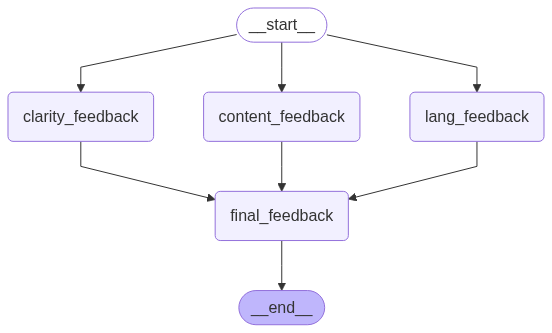

In [48]:
workflow

In [49]:
input = {"essay":essay}
output_state = workflow.invoke(input)

In [50]:
output_state

{'essay': "\nThe Rise of Artificial Intelligence\nIn recent years, Artificial Intelligence (AI) has emerged as one of the most transformative forces in modern technology. From self-driving cars and virtual assistants to advanced medical diagnostics and content creation, AI is rapidly reshaping industries and the way we live. The rise of AI is not just a technological trend; it represents a fundamental shift in how humans interact with machines, data, and the world around them.\n\nThe roots of AI can be traced back to the mid-20th century, when scientists first began exploring the idea of machines that could simulate human intelligence. However, progress was slow due to limited computing power and lack of data. The situation changed dramatically in the 21st century with the explosion of digital data, the development of powerful computing hardware, and breakthroughs in machine learning—particularly deep learning and neural networks. These advancements allowed AI systems to learn from mas

In [51]:
essay_with_mistakes = """
The Important of Education in Modern Society

Education is plays very crucial role in today's world. It is not just about learning facts and figures, but it help people to develop critical thinking skills and prepare for there future careers. In this essay, I will discuss why education are so important and how it impact our lives.

First of all, education provide people with knowledge and skills what they need to succeed in life. When student go to school, they learns many different subjects like math, science, history, and literature. This knowledge help them to understand the world around them better. For example, learning science help people to understand how things work, while studying history teach them about past events and there lessons.

Moreover, education also help people to develop important life skills. In school, students learn how to work with others, how to solve problems, and how to communicate effective. These skills is very valuable in workplace and in personal relationships. When people have good education, they can think more clearly and make better decisions in there life.

Another important benefit of education is that it open many opportunities for people. Those who have good education usually get better jobs and earn more money. They also have more choices about what career they want to pursue. Education give people the freedom to choose there own path in life instead of being limited to few options.

Furthermore, education help to reduce poverty and inequality in society. When more people have access to quality education, they can improve there economic situation and live better lives. This not only benefit individuals but also help to strengthen the whole community and country.

However, there is still many challenges in education system today. Some schools don't have enough resources or qualified teachers. Also, not all children around the world have same access to education. These problems need to be address if we want education to reach its full potential.

In conclusion, education is extremely important for individual development and social progress. It provide knowledge, develop skills, create opportunities, and help reduce inequality. Although there is challenges, we must continue to invest in education because it is the foundation of successful and prosperous society. Every person deserve access to quality education, regardless of there background or circumstances.
"""

# Test with the essay containing mistakes
input_mistakes = {"essay": essay_with_mistakes}
output_state_mistakes = workflow.invoke(input_mistakes)

In [52]:
output_state_mistakes

{'essay': "\nThe Important of Education in Modern Society\n\nEducation is plays very crucial role in today's world. It is not just about learning facts and figures, but it help people to develop critical thinking skills and prepare for there future careers. In this essay, I will discuss why education are so important and how it impact our lives.\n\nFirst of all, education provide people with knowledge and skills what they need to succeed in life. When student go to school, they learns many different subjects like math, science, history, and literature. This knowledge help them to understand the world around them better. For example, learning science help people to understand how things work, while studying history teach them about past events and there lessons.\n\nMoreover, education also help people to develop important life skills. In school, students learn how to work with others, how to solve problems, and how to communicate effective. These skills is very valuable in workplace and